In [1]:
import pandas as pd
import numpy as np
from datetime import date, datetime, time, timedelta
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import plot_importance

from sklearn import preprocessing

%config InlineBackend.figure_format = 'retina' 
%matplotlib inline

 
mpl.rcParams['lines.linewidth'] = 2

figsize=(12,9)

np.random.seed(238746)


import warnings
warnings.filterwarnings("ignore")

In [2]:
SplitTestDate = "2019-06-23"

In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def split_date(X,y,d):
    X_te = X[d:]
    y_te = y[d:]
    X_tr = X[:d]
    y_tr = y[:d]
    return X_tr, X_te, y_tr, y_te 

def plot_results(ytrue, prediction, label):
    df_ytrue = pd.DataFrame(ytrue)
    df_ytrue['predicted'] =  prediction 
    plt.plot(df_ytrue[label],label='data')
    plt.plot(df_ytrue['predicted'],label='predicted')
    plt.xticks(rotation=45)
    mape = mean_absolute_percentage_error(df_ytrue[label],df_ytrue['predicted'])

    plt.title("Forecasting on Test Set MAPE=%.3f"%mape)
    plt.legend();
    plt.show()

In [4]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=123)
min_max_scaler = preprocessing.MinMaxScaler()

def scale(feature, scaler = min_max_scaler):
    size = len(feature)
    return scaler.fit_transform(np.array([feature]).reshape(size, 1)).T[0]
def unscale(scaled, original, scaler = min_max_scaler):
    size2 = len(scaled)
    size1 = len(original)
    return scaler.fit(np.array([original]).reshape(size1, 1)).inverse_transform(np.array([scaled]).reshape(size2, 1)).T[0]

In [5]:
df = pd.read_csv('data/processed_train.csv',index_col = 0)
df_test = pd.read_csv('data/processed_test.csv',index_col = 0)

df = df.loc[df.scope == 1]
df_test = df_test.loc[df.scope == 1]
df.date = df.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))
df_test.date = df_test.date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

df = df.sort_values(by=["date",'sku'])
df_test = df_test.sort_values(by=["date",'sku'])

Creo un dataframe utile a riscalare i target

In [6]:
rescale_df = pd.concat([df,df_test])[["target","sku"]].dropna()

In [7]:
rescale_df

,target,sku
264,66431.0,144
528,69788.0,546
792,32822.0,549
1056,111678.0,554
1188,66652.0,686
...,...,...
48,38087.0,1035
98,24597.0,1051
148,27794.0,1058
198,79456.0,1065


In [8]:
df = pd.concat([df,df_test])
df.tail()

,date,sku,price,volume_on_promo w-1,sales w-1,scope,sales w-2,sales w-3,rolling1,rolling2,...,scaled_year,scaled_dayofyear,scaled_dayofmonth,scaled_weekofyear,scaled_target,target,group_A,group_B,BRAND2,BRAND4
49,2019-12-14,1035,0.55,36.060336,38087.0,1,35633.0,35221.0,38087.0,36860.0,...,1.0,0.950139,0.433333,0.960784,NaN,NaN,True,False,True,False
99,2019-12-14,1051,2.99,100.000000,24597.0,1,42545.0,43650.0,24597.0,33571.0,...,1.0,0.950139,0.433333,0.960784,NaN,NaN,False,True,False,True
149,2019-12-14,1058,0.56,25.368425,27794.0,1,25438.0,25172.0,27794.0,26616.0,...,1.0,0.950139,0.433333,0.960784,NaN,NaN,True,False,False,True
199,2019-12-14,1065,0.57,37.921239,79456.0,1,72675.0,71502.0,79456.0,76065.5,...,1.0,0.950139,0.433333,0.960784,NaN,NaN,True,False,False,True
299,2019-12-14,1206,0.56,29.153580,37889.0,1,34242.0,35238.0,37889.0,36065.5,...,1.0,0.950139,0.433333,0.960784,NaN,NaN,True,False,False,True


In [9]:

simple_df = df[['scaled_quarter','scaled_month','scaled_year','scaled_price_diff1',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2",
                "date","sku","scaled_target","target"]]
simple_df = simple_df.dropna().set_index("date")
simple_train = simple_df[:SplitTestDate].reset_index()
simple_test = simple_df[SplitTestDate:].reset_index()

In [10]:
simple_test.tail()

,date,scaled_quarter,scaled_month,scaled_year,scaled_price_diff1,group_A,group_B,BRAND2,BRAND4,scaled_dayofyear,...,scaled_sales3,scaled_promo,scaled_diff1,scaled_diff2,percentage_diff1,scaled_price,scaled_rolling2,sku,scaled_target,target
283,2019-12-07,1.0,1.0,1.0,-0.000000,True,False,True,False,0.930748,...,0.320618,0.005047,-0.002800,0.238812,-0.011562,0.961538,0.080406,1035,0.098481,38087.0
284,2019-12-07,1.0,1.0,1.0,-0.182243,False,True,False,True,0.930748,...,0.447331,1.000000,0.018063,-0.158155,0.025972,0.299065,0.614518,1051,0.312093,24597.0
285,2019-12-07,1.0,1.0,1.0,-0.000000,True,False,False,True,0.930748,...,0.322920,0.176090,-0.002593,0.223117,-0.010457,0.961538,0.098507,1058,0.122768,27794.0
286,2019-12-07,1.0,1.0,1.0,-0.000000,True,False,False,True,0.930748,...,0.308974,0.181504,-0.005164,0.225759,-0.016140,0.750000,0.080634,1065,0.113069,79456.0
287,2019-12-07,1.0,1.0,1.0,0.030303,True,False,False,True,0.930748,...,0.300373,0.066768,0.008531,0.249407,0.029087,0.727273,0.055231,1206,0.082205,37889.0


In [11]:
X_train = simple_train[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [12]:
y_train = simple_train[["date","sku","scaled_target","target"]]

In [13]:
X_test = simple_test[['scaled_month',
            "group_A","group_B","BRAND2","BRAND4",
           'scaled_dayofyear','scaled_dayofmonth','scaled_weekofyear',"scaled_sales1","scaled_sales2","scaled_sales3",
            'scaled_promo','scaled_diff1','scaled_diff2','percentage_diff1','scaled_price',"scaled_rolling2"]]

In [14]:
y_test = simple_test[["date","sku","scaled_target","target"]]

In [15]:
y_test

,date,sku,scaled_target,target
0,2019-06-29,144,0.063781,16228.0
1,2019-06-29,546,0.071891,61407.0
2,2019-06-29,549,0.108526,33777.0
3,2019-06-29,554,0.155733,122673.0
4,2019-06-29,686,0.087701,21177.0
...,...,...,...,...
283,2019-12-07,1035,0.098481,38087.0
284,2019-12-07,1051,0.312093,24597.0
285,2019-12-07,1058,0.122768,27794.0
286,2019-12-07,1065,0.113069,79456.0


In [16]:
groups = [col for col in X_train.columns if 'group' in col]
groups

['group_A', 'group_B']

9
group_A


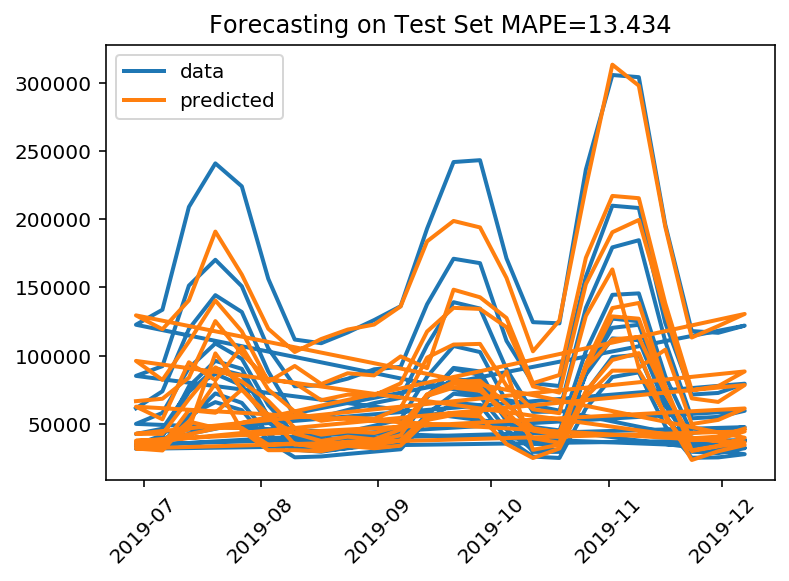

3
group_B


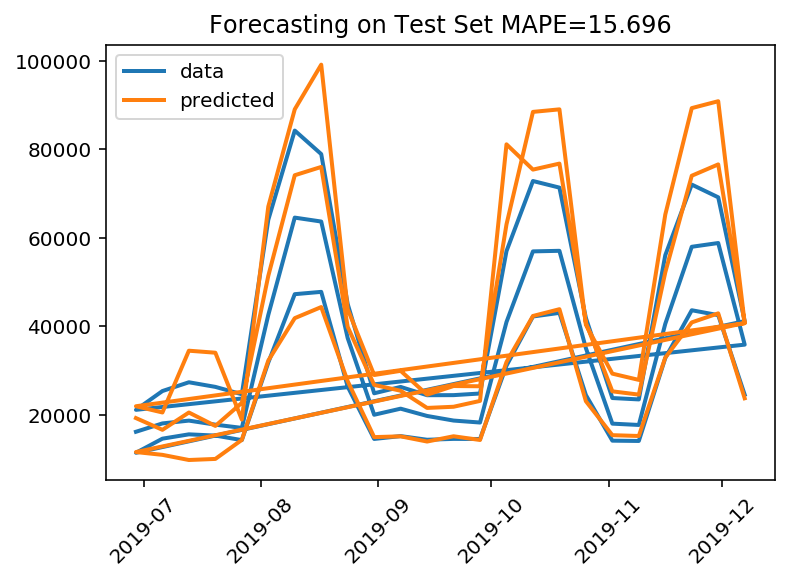

In [17]:
for g in groups:
    if g == "Not_grouped":
        continue
    y_traing = y_train.loc[X_train[g]]
    X_traing = X_train.loc[X_train[g]].drop(columns = groups)
    y_testg = y_test.loc[X_test[g]]
    X_testg = X_test.loc[X_test[g]].drop(columns = groups)
    
    
    sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
    X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

    sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
    X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)

    
    
    model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.06)
    
    #xgb.XGBRegressor(n_estimators=500, learning_rate=0.1) #MAPE 10.9, 13.0, 6.09, 6.5, 14.77
    #CatBoostRegressor(iterations=500,learning_rate=0.1,eval_metric='MAPE') #MAPE =  11.1, 13.3, 7.6, 6.4,18
    #xgb.XGBRegressor(n_estimators=500, learning_rate=0.5) #MAPE 10.8, 14.9, 6.0, 6.4, 16.3
    #RandomForestRegressor(n_estimators=200,random_state=123) #MAPE 11.264, 12.636, 6.997, 6.387, 14.661
    #RandomForestRegressor(n_estimators=10,random_state=123) #MAPE 11.232, 11.994, 7.616, 6.068, 14.320

    
    model.fit(X_traing, y_traing["scaled_target"])

    prediction = model.predict(X_testg)

    results = pd.DataFrame(columns = ["date","sku","target","prediction"])

    for sku in y_testg["sku"].unique():

        pred_sku = prediction[np.where(y_testg["sku"] == sku)]
        originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals)

        results = pd.concat([results, pd.DataFrame({
            "date" : y_testg[y_testg["sku"] == sku]["date"],
            "sku" : y_testg[y_testg["sku"] == sku]["sku"],
            "target" : y_testg[y_testg["sku"] == sku]["target"],
            "prediction" : pred
        })])
    print(len(y_testg["sku"].unique()))

    print(g)
    results = results.dropna().set_index("date")

    plot_results(results["target"], results["prediction"], "target")


12
group_B


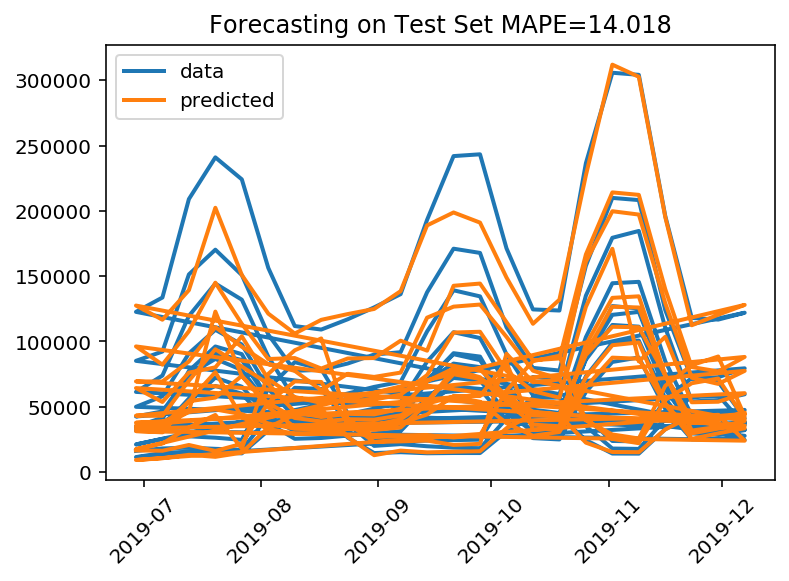

In [18]:
y_traing = y_train
X_traing = X_train
y_testg = y_test
X_testg = X_test


sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)



model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.06)

#xgb.XGBRegressor(n_estimators=500, learning_rate=0.1) #MAPE 10.9, 13.0, 6.09, 6.5, 14.77
#CatBoostRegressor(iterations=500,learning_rate=0.1,eval_metric='MAPE') #MAPE =  11.1, 13.3, 7.6, 6.4,18
#xgb.XGBRegressor(n_estimators=500, learning_rate=0.5) #MAPE 10.8, 14.9, 6.0, 6.4, 16.3
#RandomForestRegressor(n_estimators=200,random_state=123) #MAPE 11.264, 12.636, 6.997, 6.387, 14.661
#RandomForestRegressor(n_estimators=10,random_state=123) #MAPE 11.232, 11.994, 7.616, 6.068, 14.320


model.fit(X_traing, y_traing["scaled_target"])

prediction = model.predict(X_testg)

results = pd.DataFrame(columns = ["date","sku","target","prediction"])

for sku in y_testg["sku"].unique():

    pred_sku = prediction[np.where(y_testg["sku"] == sku)]
    originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
    pred = unscale(pred_sku,originals)

    results = pd.concat([results, pd.DataFrame({
        "date" : y_testg[y_testg["sku"] == sku]["date"],
        "sku" : y_testg[y_testg["sku"] == sku]["sku"],
        "target" : y_testg[y_testg["sku"] == sku]["target"],
        "prediction" : pred
    })])
print(len(y_testg["sku"].unique()))

print(g)
results = results.dropna().set_index("date")

plot_results(results["target"], results["prediction"], "target")

In [19]:
y_test.loc[y_test["date"] == "2019-06-29"].sku

0      144
1      546
2      549
3      554
4      686
5      688
6     1027
7     1035
8     1051
9     1058
10    1065
11    1206
Name: sku, dtype: int64

In [35]:
y_traing = y_train
X_traing = X_train

sku_dummies = pd.get_dummies(y_traing["sku"]) > 0
sku_dummies_df = pd.DataFrame(sku_dummies, index = X_traing.index)
X_traing = pd.concat([sku_dummies_df,X_traing],axis = 1)

predictions = []
model = None
tot_mape = 0
nw = 0
for week in y_test.date.unique():

    nw = nw + 1
    print(week)
    X_testg = X_test.loc[y_test.date == week]
    y_testg = y_test.loc[y_test.date == week]
    
    

    sku_dummies = pd.get_dummies(y_testg["sku"]) > 0
    sku_dummies_df = pd.DataFrame(sku_dummies, index = X_testg.index)
    X_testg = pd.concat([sku_dummies_df,X_testg],axis = 1)
    model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.1)
    
    model.fit(X_traing, y_traing["scaled_target"])
    
    week_pred = model.predict(X_testg)

    
    
    unscale_pred = []
    for sku in y_testg["sku"]:
        pred_sku = week_pred[np.where(y_testg["sku"] == sku)]
        originals = rescale_df.loc[rescale_df["sku"] == sku]["target"]
        pred = unscale(pred_sku,originals) 
        unscale_pred = np.append(unscale_pred,pred) 
    

    predictions = np.append(predictions,unscale_pred)

    
    week_mape = mean_absolute_percentage_error(y_testg.target, unscale_pred)
    tot_mape = tot_mape + week_mape
    
    print(tot_mape/nw)
    
    
    X_traing = pd.concat([X_traing,X_testg])
    y_traing = pd.concat([y_traing,y_testg])
    
    
print(tot_mape/nw)    


    

2019-06-29T00:00:00.000000000
10.103157733169288
2019-07-06T00:00:00.000000000
9.878183270271396
2019-07-13T00:00:00.000000000
13.393345831181449
2019-07-20T00:00:00.000000000
15.849645322373508
2019-07-27T00:00:00.000000000
14.523058491414483
2019-08-03T00:00:00.000000000
14.708720569196679
2019-08-10T00:00:00.000000000
14.996438173885219
2019-08-17T00:00:00.000000000
14.576067725800394
2019-08-24T00:00:00.000000000
13.99103539048533
2019-08-31T00:00:00.000000000
13.089598143651633
2019-09-07T00:00:00.000000000
12.421909237700635
2019-09-14T00:00:00.000000000
12.140133854215648
2019-09-21T00:00:00.000000000
11.480037626558188
2019-09-28T00:00:00.000000000
10.902790571510526
2019-10-05T00:00:00.000000000
11.75519921751919
2019-10-12T00:00:00.000000000
11.433703077695498
2019-10-19T00:00:00.000000000
11.250078089912217
2019-10-26T00:00:00.000000000
11.059974213366226
2019-11-02T00:00:00.000000000
10.815246622602421
2019-11-09T00:00:00.000000000
10.514021532952016
2019-11-16T00:00:00.000

In [34]:
print(tot_mape/(nw))    


10.418912352460575


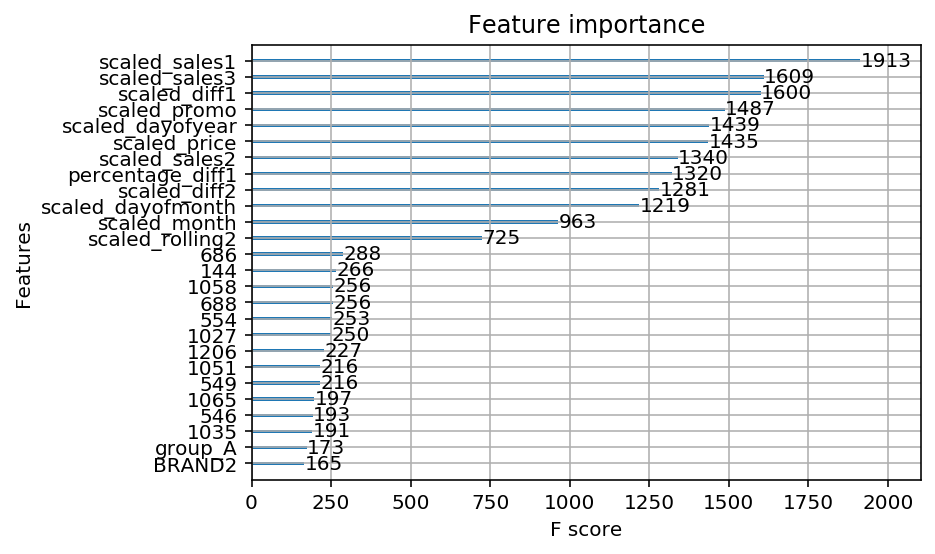

In [22]:
plot_importance(model)